In [9]:
import argparse
import os
import requests
from datetime import datetime
import json

from lib.utils import *
from lib.datasets import EEGDataset
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.functional import softmax,batch_norm,relu
from torch import nn
import torch
from lib.models import ResNet as MODEL
device = 'cuda'

data_dir = 'data_pt'
# train_dataloader = DataLoader(EEGDataset(dir=f'{data_dir}/train',labels=f'{data_dir}/y_train.pt'), batch_size=64, shuffle=True)
# test_dataloader = DataLoader(EEGDataset(dir=f'{data_dir}/test',labels=f'{data_dir}/y_test.pt'), batch_size=64, shuffle=False)

warmstart = False

In [233]:
class ResNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        ## block 1
        n_feature_maps = 64
        self.c1 = nn.Conv1d(1,n_feature_maps,kernel_size=8,padding='same',bias=False)
        self.bn1 = nn.BatchNorm1d(n_feature_maps,momentum=.01)

        self.c2 = nn.Conv1d(n_feature_maps,n_feature_maps,kernel_size=5,padding='same',bias=False)
        self.bn2 = nn.BatchNorm1d(n_feature_maps,momentum=.01)

        self.c4 = nn.Conv1d(1,n_feature_maps,1,padding='same',bias=False)
        self.bn4 = nn.BatchNorm1d(n_feature_maps,momentum=.01)

        ## final
        self.gap = nn.AvgPool1d(kernel_size=500)
        self.lstm = nn.LSTM(64,64)
        self.fc1 = nn.Linear(in_features=n_feature_maps,out_features=3)

    def forward(self,x):
        identity = x
        x = self.c1(x)
        x = self.bn1(x)
        x = relu(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = relu(x)

        identity = self.c4(identity)
        identity = self.bn4(identity)

        x = x+identity
        x = relu(x)
        
        ## final
        x = self.gap(x)
        out,_ = self.lstm(x.view(5,1,64))
        x = self.fc1(out.view(5,-1))
        return x

In [361]:
X,y = load_raw_list([20,21,22])
X = X[:,::10]
X = X[:len(X)-len(X)%5]
y = y[:len(y)-len(y)%5]
X = X.view(-1,5,1,500)
y = y.view(-1,5)

In [365]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

In [370]:

trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=32,shuffle=True)


In [371]:
model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
train_losses = []
dev_losses = []

In [372]:
lossi = []

In [375]:
for X,y in trainloader:
    logits = model(X)
    loss = criterion(logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 5, 1, 500]

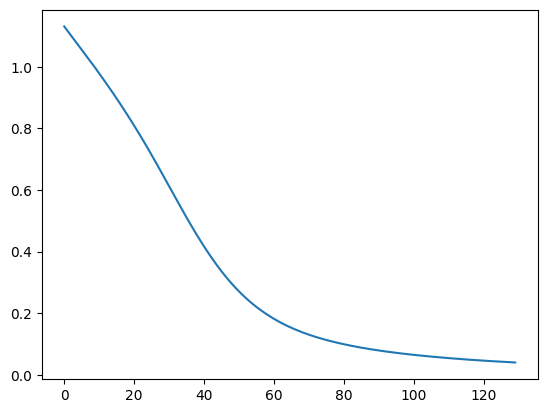

In [374]:
plt.plot(lossi)